In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

import shap
shap.initjs()

In [2]:
#Load the data
data, labels = shap.datasets.adult(display=True)

#Store the label in numpy array
labels = pd.Series(np.array([int(label) for label in labels]), name='labels')

data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [3]:
#Check the shape
data.shape, labels.shape

((32561, 12), (32561,))

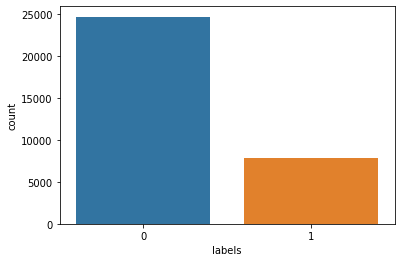

In [4]:
#View the distribution of labels
sns.countplot(labels)

### Feature Engineering

In [5]:
#Get the categorical columns and numeric columns
cat_cols = data.select_dtypes(['category']).columns
num_cols = list(set(data.columns) - set(cat_cols))
print("Numeric columns: ", num_cols)
print("Categorical columns: ", cat_cols)

Numeric columns:  ['Capital Loss', 'Hours per week', 'Capital Gain', 'Education-Num', 'Age']
Categorical columns:  Index(['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Country'],
      dtype='object')


In [6]:
#Perform LabelEncoding on categorical columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


#### Split the data into training and testing

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.75, random_state=42)
print(X_train.shape, X_test.shape)

(24420, 12) (8141, 12)


#### Build a classifier model

In [14]:
import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimator=1000, max_depth=5)
xgc_model = xgc.fit(X_train, y_train)
y_pred = xgc_model.predict(X_test)

[10:20:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [16]:
#Problem in explainer for XGboost newer version. Ref: https://github.com/slundberg/shap/issues/1215
xgc_booster = xgc_model.get_booster()
model_bytearray = xgc_booster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
xgc_booster.save_raw = myfun

In [17]:
#Calculate the accuracy and f1-score
from sklearn.metrics import accuracy_score, f1_score, classification_report
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("F1-score: ", f1_score(y_test, y_pred))
classification_report(y_test, y_pred)

Accuracy score:  0.8758137820906523
F1-score:  0.7164095371669004


'              precision    recall  f1-score   support\n\n           0       0.90      0.94      0.92      6214\n           1       0.78      0.66      0.72      1927\n\n    accuracy                           0.88      8141\n   macro avg       0.84      0.80      0.82      8141\nweighted avg       0.87      0.88      0.87      8141\n'

## SHAP

#### SHAP assigns each feature an importance value. 

In [18]:
#Create an explainer for xgboost model
explainer = shap.TreeExplainer(xgc)

#Find the shap values using the explainer
shap_values = explainer.shap_values(X_test)

#Print the expected/ base value (avg value without knowledge of features)
print("Base value: ", explainer.expected_value)

#Print 1st 5 values of SHAP value table
pd.DataFrame(shap_values).head()

Base value:  -1.4157494


,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.128322,0.001098,-0.061439,-0.940105,-0.333496,-0.567386,-0.006345,-0.367118,-0.139750,-0.031370,-0.640342,0.008117
1,0.351972,-0.192834,-0.433446,0.593105,0.433306,1.101579,0.011046,-0.138193,-0.115032,-0.048570,-0.090653,0.022812
2,-0.430079,0.053450,0.864086,0.348882,0.548031,0.648198,-0.074380,0.055832,-0.170812,-0.090771,0.474241,0.034960
3,-0.338432,0.054231,0.561316,-1.016731,-0.415855,-0.612123,0.014358,-0.287760,-0.138729,-0.048846,-0.202127,0.021468
4,-0.352963,-0.311335,-0.130011,-0.465382,0.005486,-0.415694,-0.034255,0.075723,-2.996368,-0.034732,0.752424,0.005719


This returns a matrix of SHAP values (# samples, # features). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as expected_value attribute of the explainer).

Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome. You'll see shap_values being used multiple times now.

Also, the Expected Value: -1.3625857 being displayed above will be used as the base value throughout all the visualizations below. The values above this base value will be put into class 1 (income exceeds 50K/yr) wheras the values below it will be put into class 0 (income doesn't exceed 50K/yr).

In [20]:
#Get the original data again to compare
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)

In [23]:
#Dispay a force plot for row 0 
print("Actual label: ", y_test_disp[0])
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test_disp.iloc[0,:])

Actual label:  False


In [24]:
#Dispay a force plot for row 5 
print("Actual label: ", y_test_disp[5])
shap.force_plot(explainer.expected_value, 
                shap_values[5,:], X_test_disp.iloc[5,:])

Actual label:  True


In [27]:
#Dispay a force plot for multiple rows
shap.force_plot(explainer.expected_value, 
                shap_values[0:100,:], X_test_disp.iloc[0:100,:])

### Feature importance using SHAP

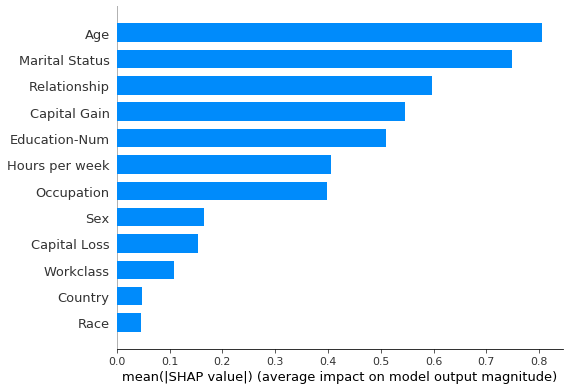

In [28]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

From the above simple bar chart, we observe that Age and Marital Features are the top 2 important features while determining the income.

On the other hand, Country and Race are the least important features while determining the income.

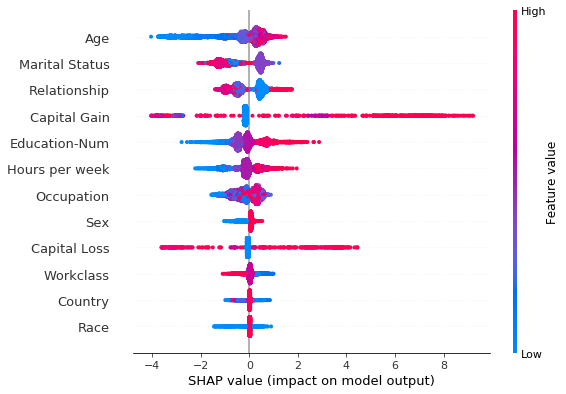

In [29]:
#Summary plot
shap.summary_plot(shap_values, X_test)

In the above plot, we have provided all the features in X_test to the Summary Plot. We can also provide some specific features instead.

It is interesting to note that the age and marital status feature has more total model impact than the capital gain feature. (Since they lie on the top and the Feature Value bar indicates high there).

But, for those samples where capital gain matters, it has more impact than age or marital status. (Since its SHAP value is the highest amongst all).

In other words, capital gain affects a few predictions by a large amount, while age or marital status affects all predictions by a smaller amount.

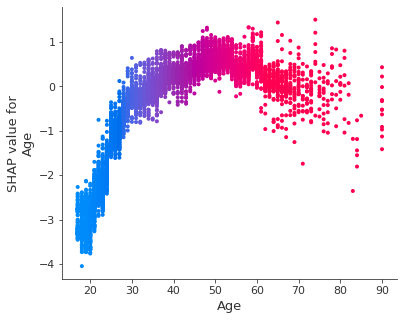

In [30]:
#SHAP dependence plot: Effect of one feature on whole dataset by plotting shap's values vs feature value
shap.dependence_plot(ind='Age', interaction_index='Age', shap_values=shap_values, features=X_test)

Just like we observed before. the middle-aged people have a slightly higher shap value, pushing the model’s prediction decisions to say that these individuals make more money as compared to younger or older people

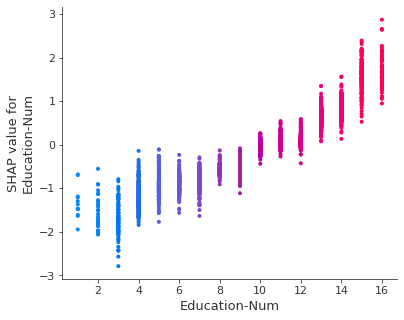

In [37]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num', shap_values=shap_values, features=X_test)

Higher education levels have higher shap values, pushing the model’s prediction decisions to say that these individuals make more money as compared to people with lower education levels.

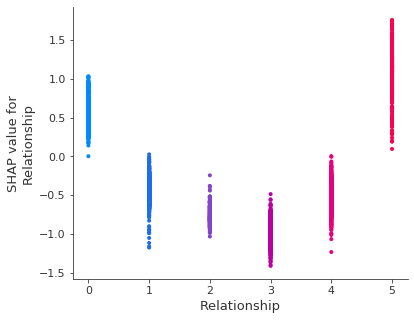

In [38]:
shap.dependence_plot(ind='Relationship', interaction_index='Relationship', shap_values=shap_values, features=X_test)

Just like we observed during the model prediction explanations, married people (husband or wife) have a slightly higher shap value, pushing the model’s prediction decisions to say that these individuals make more money as compared to other folks!

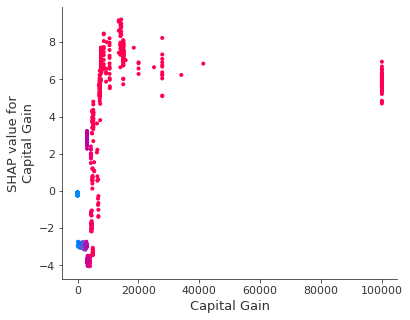

In [40]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain', shap_values=shap_values, features=X_test)

#### Two-way dependence plots

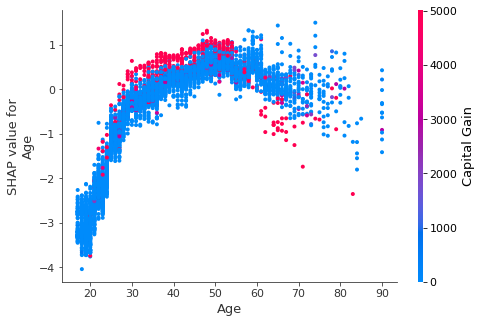

In [41]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', shap_values=shap_values, features=X_test, display_features=X_test_disp)

Higher the higher capital gain and the middle-aged folks (30–50) having the highest chance of making more money

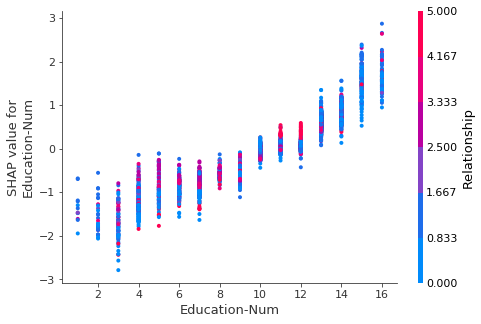

In [42]:
shap.dependence_plot(ind='Education-Num', interaction_index='Relationship', shap_values=shap_values, features=X_test)

Both the features are similar in some context, we can see typically educated and married people with relationship status of either husband(shown by light blue) or wife(shown by red) having the highest chance of making more money

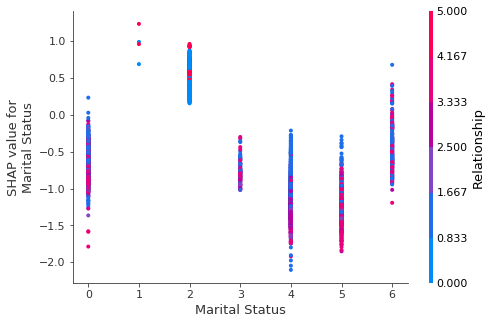

In [43]:
shap.dependence_plot(ind='Marital Status', interaction_index='Relationship', shap_values=shap_values, features=X_test)